In [52]:
import os

# Set CPU count for numpyro multi-chain multi-thread
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import pickle
import itertools

import jax
# Enable x64 for JAX
jax.config.update("jax_enable_x64", True)
#jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as np
import jax.random as jr
from jax import jit, lax

from matplotlib import pyplot as plt
from astropy import units as u
from astropy.io import fits

#from dLux.utils import arcsec_to_rad as toRad
#from dLux.utils import rad_to_arcsec as toArcsec

from dLux.utils import arcsec2rad as toRad
from dLux.utils import rad2arcsec as toArcsec

from dLuxWebbpsf.utils import grid_search
from dLuxWebbpsf import NIRCam


# before execute any computation / allocation
print(jax.numpy.ones(3).device()) # TFRT_CPU_0

def norm(data):
    return data/data.sum()

cuda:0


In [53]:
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

cmap_v = plt.colormaps["inferno"].copy()
cmap_v.set_bad('black', 1.)
cmap_v.set_under('black')
cmap_v.set_over('black')

In [54]:
webb_options = {
    'jitter': None,   # jitter model name or None
    'jitter_sigma': 0.000,  # in arcsec per axis, default 0.007
    'add_distortion': False,
}

npix = 56

source_offset_x = toRad(0.1)
source_offset_y = toRad(0.25)

offset = np.array([source_offset_x, source_offset_y])

flux = 1e9
#contrast = 100

zernike_terms=3

pri_x = source_offset_x
pri_y = source_offset_y

telescope = NIRCam(#filter = "F212N",
                filter = "F187N",
                detector = "NRCB1",
                aperture = "NRCB1_SUB64P",
                   
                fft_oversample=4,
                detector_oversample=4,
                #wavefront_downsample=8,
                fov_pixels=npix,
                options=webb_options,
                #monochromatic = 4.82792251e-06,
                #offset=offset,
                phase_retrieval_terms = zernike_terms,
                flux=flux
               )

telescope_clean = telescope

In [55]:
pixscale = toRad(telescope.psf_pixel_scale)

def toPix(value):
    ret = (value / pixscale) + npix/2 - 0.5
    return ret

In [56]:
print(telescope.psf_pixel_scale)

0.03063267


## Generate phase layers

In [57]:
basis_flat = telescope.pupil.basis

seed = 0xDEFDBE3F
coeffs = 2e-8*jr.normal(jr.PRNGKey(seed), (basis_flat.shape[0],))

telescope = telescope.set(['pupil.coefficients'], [coeffs])

In [58]:
def get_aber(coeffs, basis):
    s_coeffs = np.asarray(coeffs.reshape(coeffs.shape[0], 1, 1), dtype=float)
    s_basis = np.asarray(basis, dtype=float)
    result = s_coeffs * s_basis
    return result.sum(0)

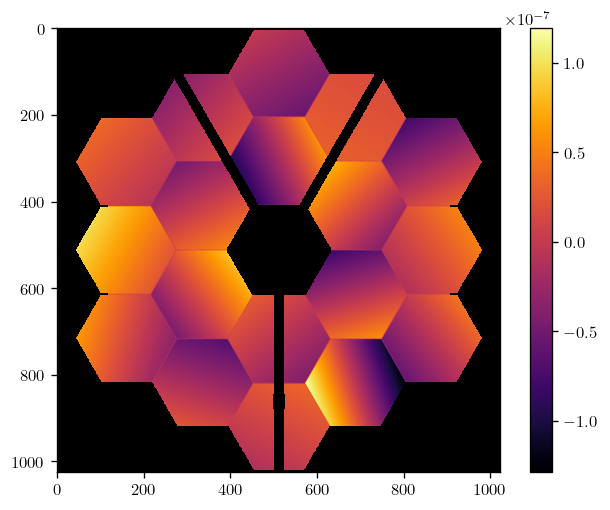

In [59]:
base_aberrations = get_aber(coeffs, basis_flat)
i_mask = np.where(telescope.pupil.transmission == 0, np.nan, telescope.pupil.transmission)
plt.imshow(base_aberrations * i_mask, cmap=cmap_v)
plt.colorbar()

In [60]:
mod_opd = None
wavelength = 4.82792251e-06

if telescope.aberrations.has_defocus:
    mod_opd = (np.polyval(telescope.aberrations.focusmodel, wavelength) - telescope.aberrations.opd_ref_focus) * telescope.aberrations.defocus_zern

(-0.5, 223.5, 223.5, -0.5)

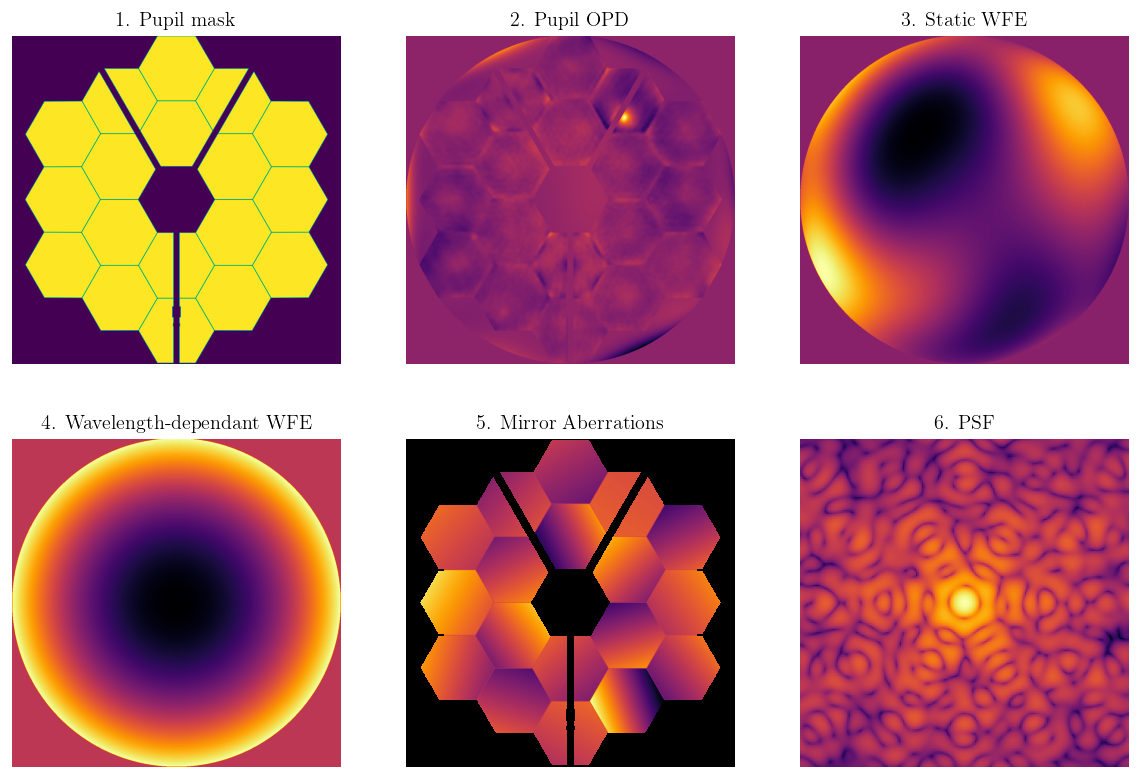

In [62]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(telescope.pupil.transmission)
plt.title("1. Pupil mask")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(telescope.pupil.opd, cmap=cmap_v)
plt.title("2. Pupil OPD")
plt.axis('off')

plt.subplot(2, 3,  3)
plt.imshow(telescope.aberrations.opd, cmap=cmap_v)
plt.title("3. Static WFE")
plt.axis('off')

plt.subplot(2, 3,  4)
plt.imshow(mod_opd, cmap=cmap_v)
plt.title("4. Wavelength-dependant WFE")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(base_aberrations * i_mask, cmap=cmap_v)
plt.title("5. Mirror Aberrations")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(psf, cmap=cmap_v, norm='log')
plt.title("6. PSF")
plt.axis('off')

## Step 2: Make an optical model for optimisation where source will be parametrised.

The solution that they have for this same problem in https://github.com/amerand/CANDID, a popular interferometry data analysis code, is to calculate the likelihood on a grid of xy with other parameters held constant, to identify the best position to start
see that page - scroll down to ‘CHI2MAP’ and ‘FITMAP’

In [13]:
@jit
def model_optics_jit():
    return telescope.model()

In [14]:
%%time
print("Modelling optics...")
psf = model_optics_jit()
print("Modelling optics...ok")

Modelling optics...
Modelling optics...ok
CPU times: user 4.06 s, sys: 14.9 s, total: 18.9 s
Wall time: 18.7 s


In [11]:
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 0.01*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data_n = psf_photon # + bg_noise

data = norm(data_n)

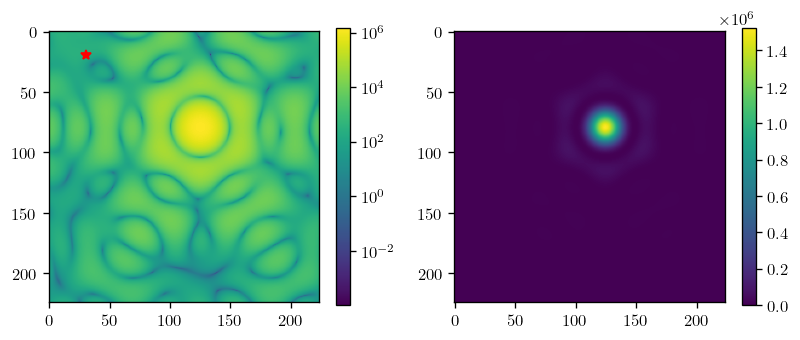

In [12]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.imshow(psf, norm="log")
plt.colorbar()

plt.plot(toPix(pri_x), toPix(-pri_y), marker='*', color="red")

plt.subplot(1, 2, 2)
plt.imshow(psf)
plt.colorbar()

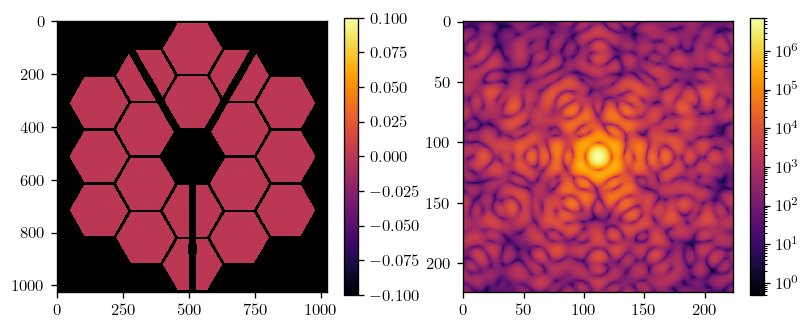

In [69]:
i_mask = np.where(telescope.pupil.transmission < 1, np.nan, telescope.pupil.transmission)

#coeffs = 2e-7*jr.normal(jr.PRNGKey(seed), (basis_flat.shape[0],))
coeffs = np.zeros(basis_flat.shape[0])

base_aberrations = get_aber(coeffs, basis_flat)
telescope = telescope.set(['pupil.coefficients'], [coeffs])

psf = telescope.model()

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.imshow(base_aberrations * i_mask, cmap=cmap_v)
plt.colorbar()


plt.subplot(1, 2, 2)
plt.imshow(psf, cmap=cmap_v, norm="log")
plt.colorbar()

Now as we got fake data, lets tru to grid search the star position so we can pass it to the HMC as initial guess. 

In [ ]:
model = telescope_clean

def likelihood(x, y, separation, angle, expected_data):
    model_data_n = model.set(['source.position'], [np.array([x, y])]).model()
    model_data = norm(model_data_n)
    residuals = expected_data - model_data
    # calculate the chi-squared value
    chi_squared = np.sum(residuals**2)
    # calculate the likelihood
    likelihood =  -0.5 * chi_squared
    return likelihood

#Make jitted version of likelihood function by using some lax magic
@jit
def likelihood_fast(x, y, separation, angle, expected_data):
    likelihood_c = lambda args : likelihood(args[0], args[1], args[2], args[3], expected_data)
    args = np.stack((x, y, separation, angle), axis=-1)
    return lax.map(likelihood_c, args)

First we search for the position of the primary star

In [ ]:
def get_single(xr, yr):
    return likelihood_fast(xr, yr, np.zeros_like(xr), np.zeros_like(xr), data)

CPU times: user 3.38 s, sys: 349 ms, total: 3.73 s
Wall time: 11.8 s


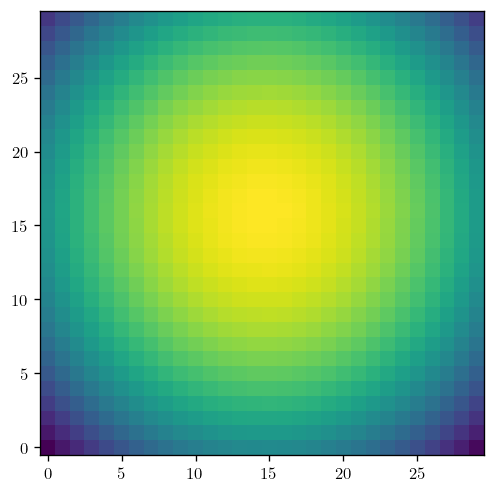

In [ ]:
%%time

pri_width = toRad(1)
pri_xr, pri_yr, tp = grid_search(get_single, 0, 0, grid_size = pri_width, grid_steps = 30, niter = 10)
plt.imshow(tp[-1]['likelihoods'], origin='lower')

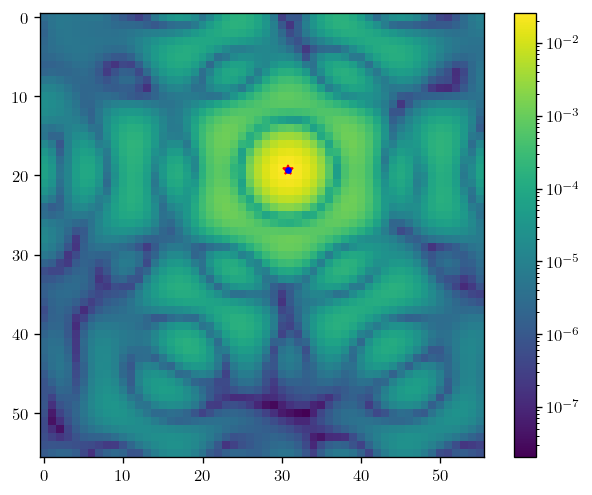

In [ ]:
plt.imshow(data, norm="log")

plt.plot(toPix(pri_x), toPix(-pri_y), marker='*', color="red")
plt.plot(toPix(pri_xr), toPix(-pri_yr), marker='.', color="blue")

plt.colorbar()

## Step 3: Set up HMC parameters and distributions.

In [17]:
std = np.sqrt(data_n).flatten()
std = np.where(std == 0, np.mean(std), std)

coord_range = toArcsec(2 * pixscale)
log_flux_range = 3

x0 = toArcsec(pri_xr)
y0 = toArcsec(pri_yr)

flux = np.sum(data_n)
log_flux = np.log(flux)

In [18]:
import numpyro as npy
import numpyro.distributions as dist

parameters = ['source.position', 'pupil.coefficients', 'source.flux']

n_mirrors = 18
n_coeffs = n_mirrors * zernike_terms

phase_scale = 1e-6

fixed_mirrors = {
    (0,0): 0,
    (1,0): 0,
    (2,0): 0,
}

def psf_model(data, data_err, model):
    """
    Define the numpyro function
    """
    
    x_sample = npy.sample("x_arcsec", dist.Uniform(x0 - coord_range, x0 + coord_range))
    y_sample = npy.sample("y_arcsec", dist.Uniform(y0 - coord_range, y0 + coord_range))
    
    phases_data = [0] * n_coeffs
    for i, z in itertools.product(range(n_mirrors), range(zernike_terms)):
        coeff_index = i*zernike_terms + z
        if (z, i) in fixed_mirrors:
            phases_data[coeff_index] = fixed_mirrors[(z,i)]
        else:
            sample = npy.sample(f'p{coeff_index}', dist.Uniform(-1,1))
            phases_data[coeff_index] = sample * phase_scale
                              
    flux_sample  = npy.sample("log_flux", dist.Uniform(log_flux - log_flux_range, log_flux + log_flux_range))
    det_flux = np.exp(flux_sample)
    
    det_x = toRad(x_sample)
    det_y = toRad(y_sample)
    
    values = [
        np.array([det_x, det_y]),
        np.array(phases_data),
        det_flux
    ]
    
    with npy.plate("data", len(data.flatten())):
        model_data = model.set(parameters, values).model().flatten()
        #model_data = norm(model_data)
        
        dist_model = dist.Normal(model_data, data_err)
        npy.sample("psf", dist_model, obs=data.flatten())
        

In [19]:
phase_scale = 1e-6

fixed_mirrors = {
    (0,0): 0,
    (1,0): 0,
    (2,0): 0,
}


parameters = ['source.position', 'pupil.coefficients', 'source.flux']

def psf_model(data, data_err, model, *, x0, y0, coord_range, log_flux, log_flux_range):
    """
    Define the numpyro function
    """
    
    x_sample = npy.sample("x_arcsec", dist.Uniform(x0 - coord_range, x0 + coord_range))
    y_sample = npy.sample("y_arcsec", dist.Uniform(y0 - coord_range, y0 + coord_range))
    
    phases_data = [0] * n_coeffs
    for i, z in itertools.product(range(n_mirrors), range(zernike_terms)):
        coeff_index = i*zernike_terms + z
        if (z, i) in fixed_mirrors:
            phases_data[coeff_index] = fixed_mirrors[(z,i)]
        else:
            sample = npy.sample(f'p{coeff_index}', dist.Uniform(-1,1))
            phases_data[coeff_index] = sample * phase_scale

    flux_sample  = npy.sample("log_flux", dist.Uniform(log_flux - log_flux_range, log_flux + log_flux_range))
    det_flux = np.exp(flux_sample)
        
    values = [
        np.array([toRad(x_sample), toRad(y_sample)]),
        np.array(phases_data),
        det_flux
    ]
    
    with npy.plate("data", len(data.flatten())):
        model_data = (model.set(parameters, values).model()).flatten()
        #model_data = norm(model_data)
        
        dist_model = dist.Normal(model_data, data_err)
        npy.sample("psf", dist_model, obs=data.flatten())

        

In [20]:
from jax import device_count

initial_values = {
    "x_arcsec": x0,
    "y_arcsec": y0,
    "log_flux": log_flux
}

for z, i in itertools.product(range(zernike_terms), range(n_mirrors)):
    if (z, i) not in fixed_mirrors:
        initial_values[f'p{i*zernike_terms + z}'] = 0

sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model, init_strategy=npy.infer.init_to_value(values=initial_values), dense_mass=True),
    num_warmup=1000,
    num_samples=1000,
    # num_chains=device_count(),
    progress_bar=True
)
%time sampler.run(jr.PRNGKey(0), data_n, std, telescope, x0 = x0, y0 = y0, coord_range = coord_range, log_flux = log_flux, log_flux_range = log_flux_range)

warmup:  41%|████      | 817/2000 [11:58<18:11,  1.08it/s, 47 steps of size 6.33e-03. acc. prob=0.79]    

Step 4: Make plots.

In [20]:
#with open("phase_values.bin", "rb") as f:
#    values_out = pickle.load(f)

sampler.print_summary()
values_out = sampler.get_samples()

#with open("phase_values.bin", "wb") as f:
#    pickle.dump(values_out, f)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  log_flux     20.72      0.00     20.72     20.72     20.72   6455.80      1.00
       p10      0.05      0.00      0.05      0.05      0.05    384.21      1.04
       p11     -0.00      0.00     -0.00     -0.01     -0.00    402.84      1.03
       p12     -0.10      0.00     -0.10     -0.10     -0.10    297.54      1.06
       p13      0.02      0.00      0.02      0.02      0.02    469.72      1.03
       p14      0.03      0.00      0.03      0.03      0.03    487.19      1.03
       p15     -0.03      0.00     -0.03     -0.03     -0.03    288.71      1.05
       p16      0.04      0.00      0.04      0.04      0.04    625.15      1.02
       p17     -0.01      0.00     -0.01     -0.01     -0.01    743.58      1.02
       p18      0.07      0.00      0.07      0.07      0.07    371.64      1.04
       p19      0.02      0.00      0.02      0.02      0.02    492.96      1.03
       p20      0.00      0

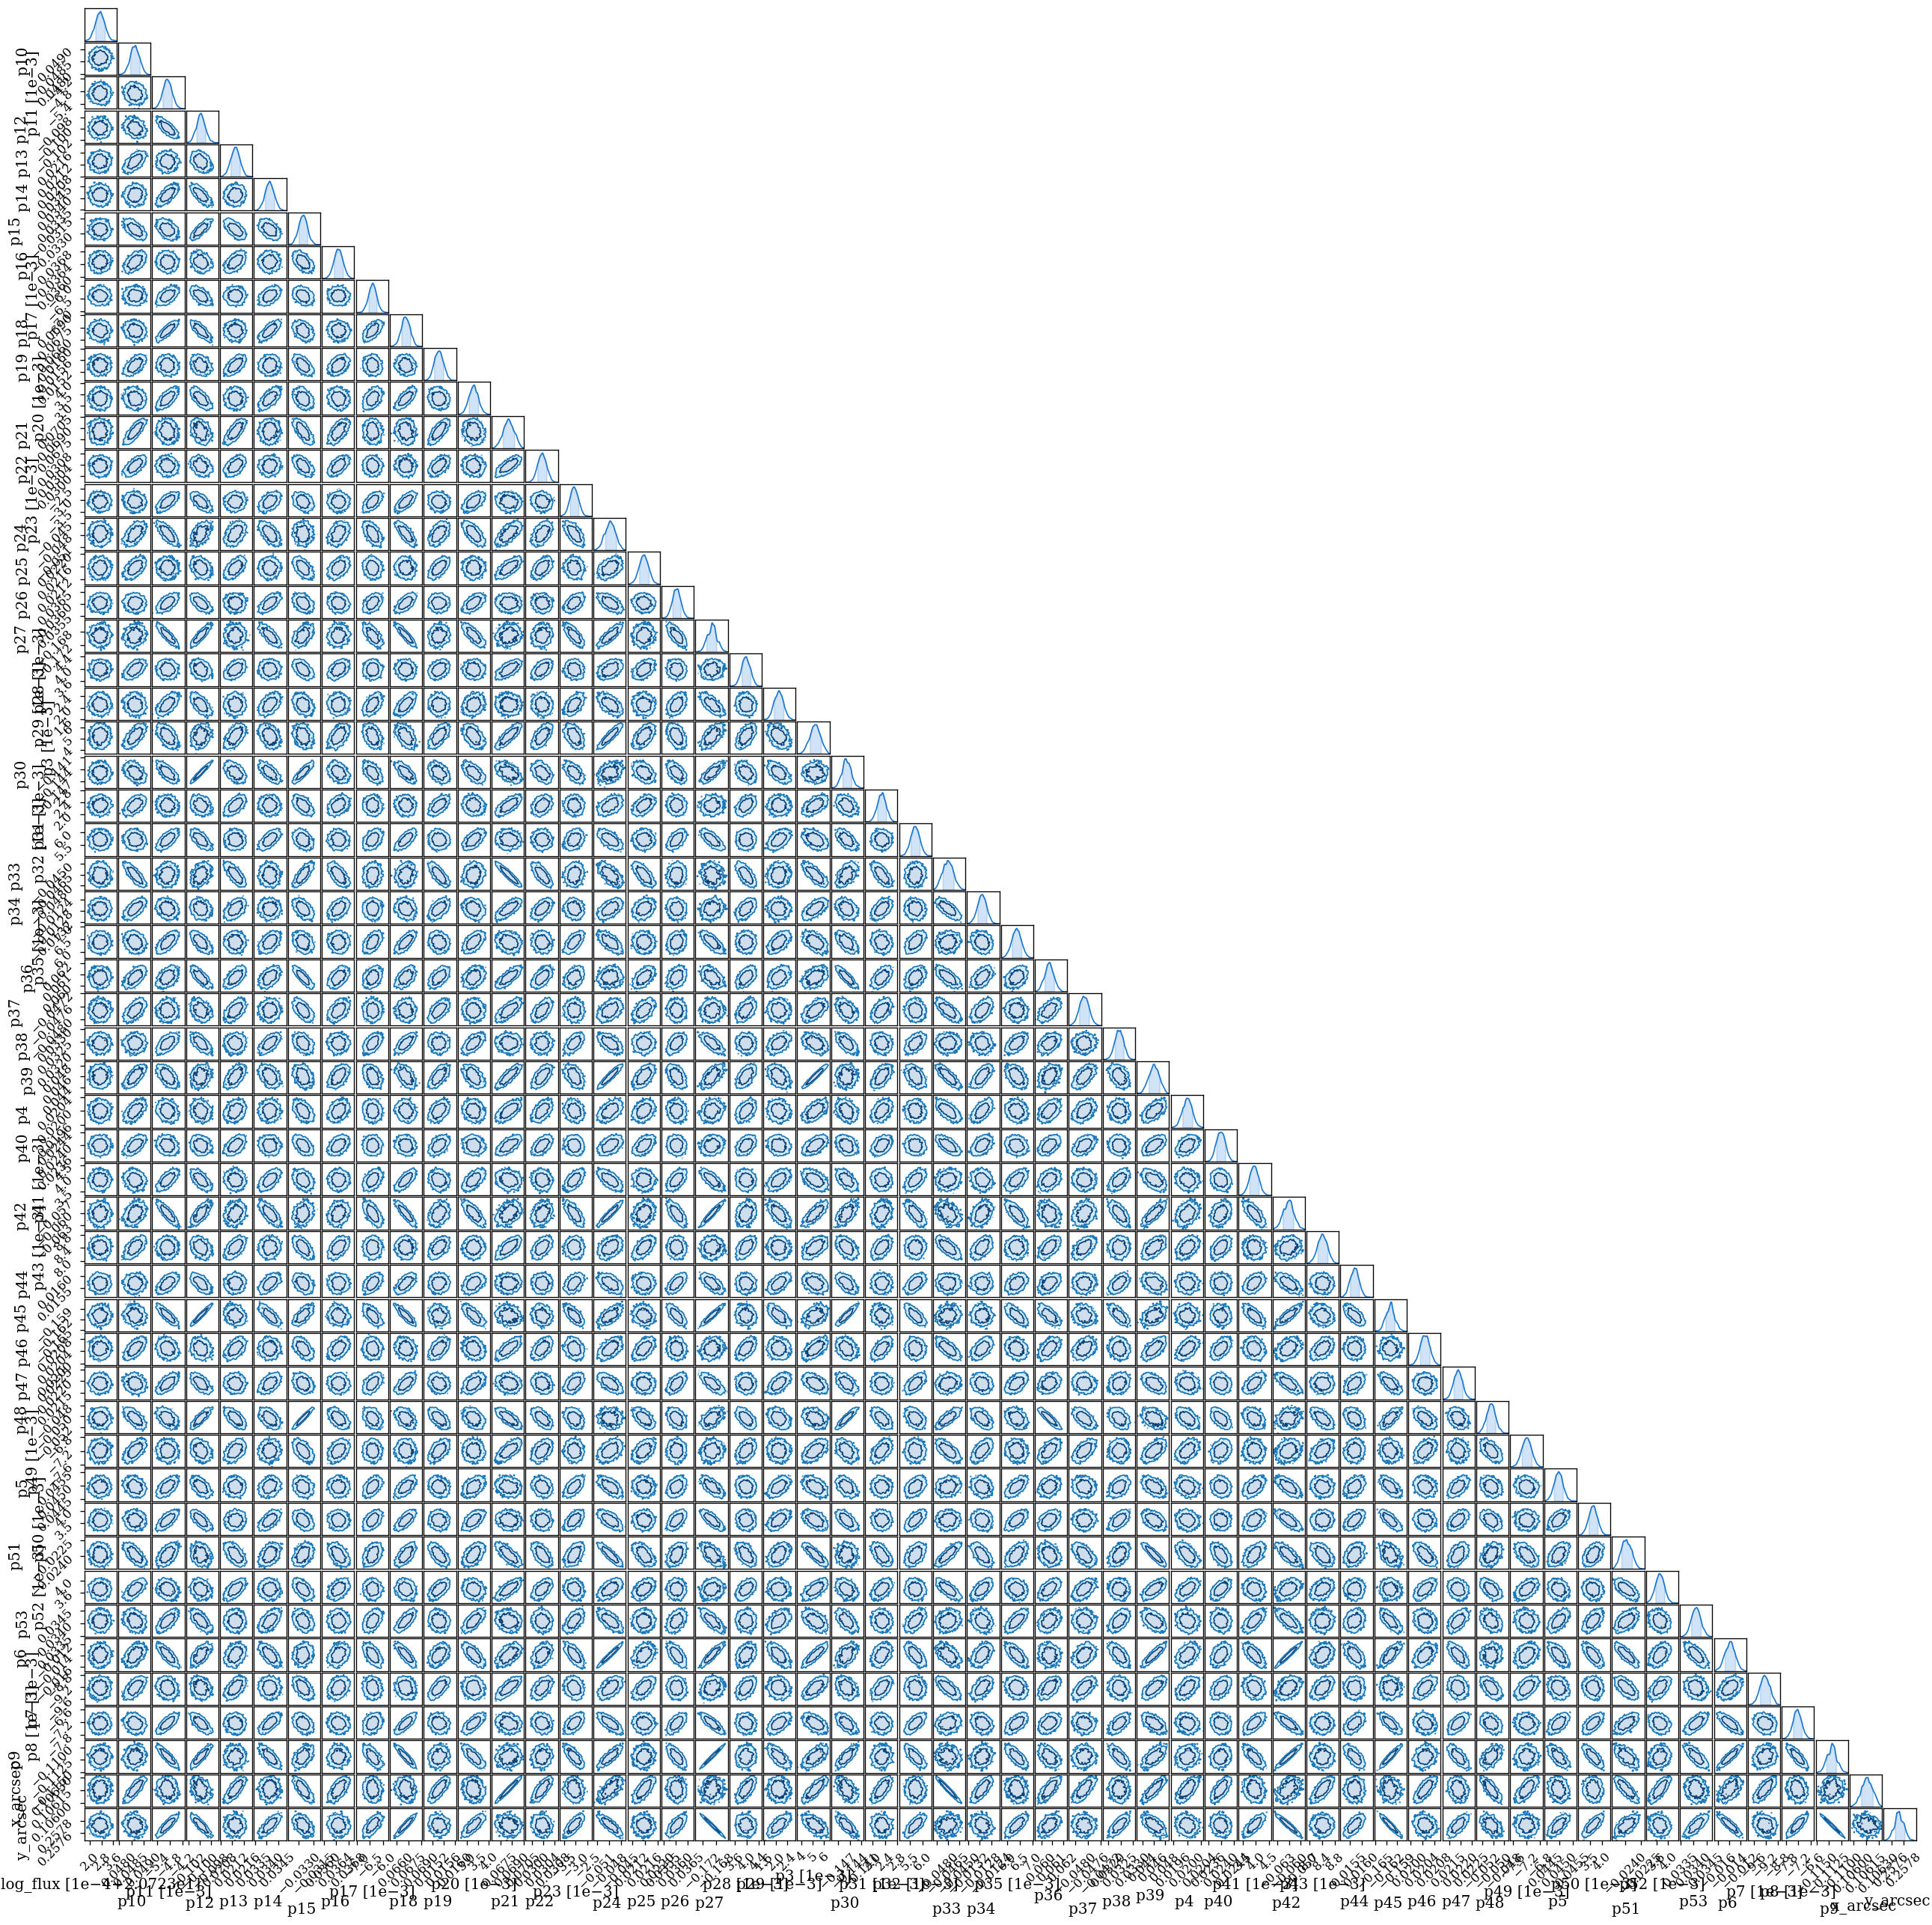

In [22]:
import chainconsumer as cc

truths = {
    "x_arcsec": toArcsec(source_offset_x),
    "y_arcsec": toArcsec(source_offset_y),
    "log_flux": np.log(flux)
}

for idx, c in enumerate(coeffs):
    truths[f'p{idx}'] = c / phase_scale

chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure_truth(color='r', ls=":", alpha=0.8)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot(truth=truths)
fig.set_size_inches((24, 24));

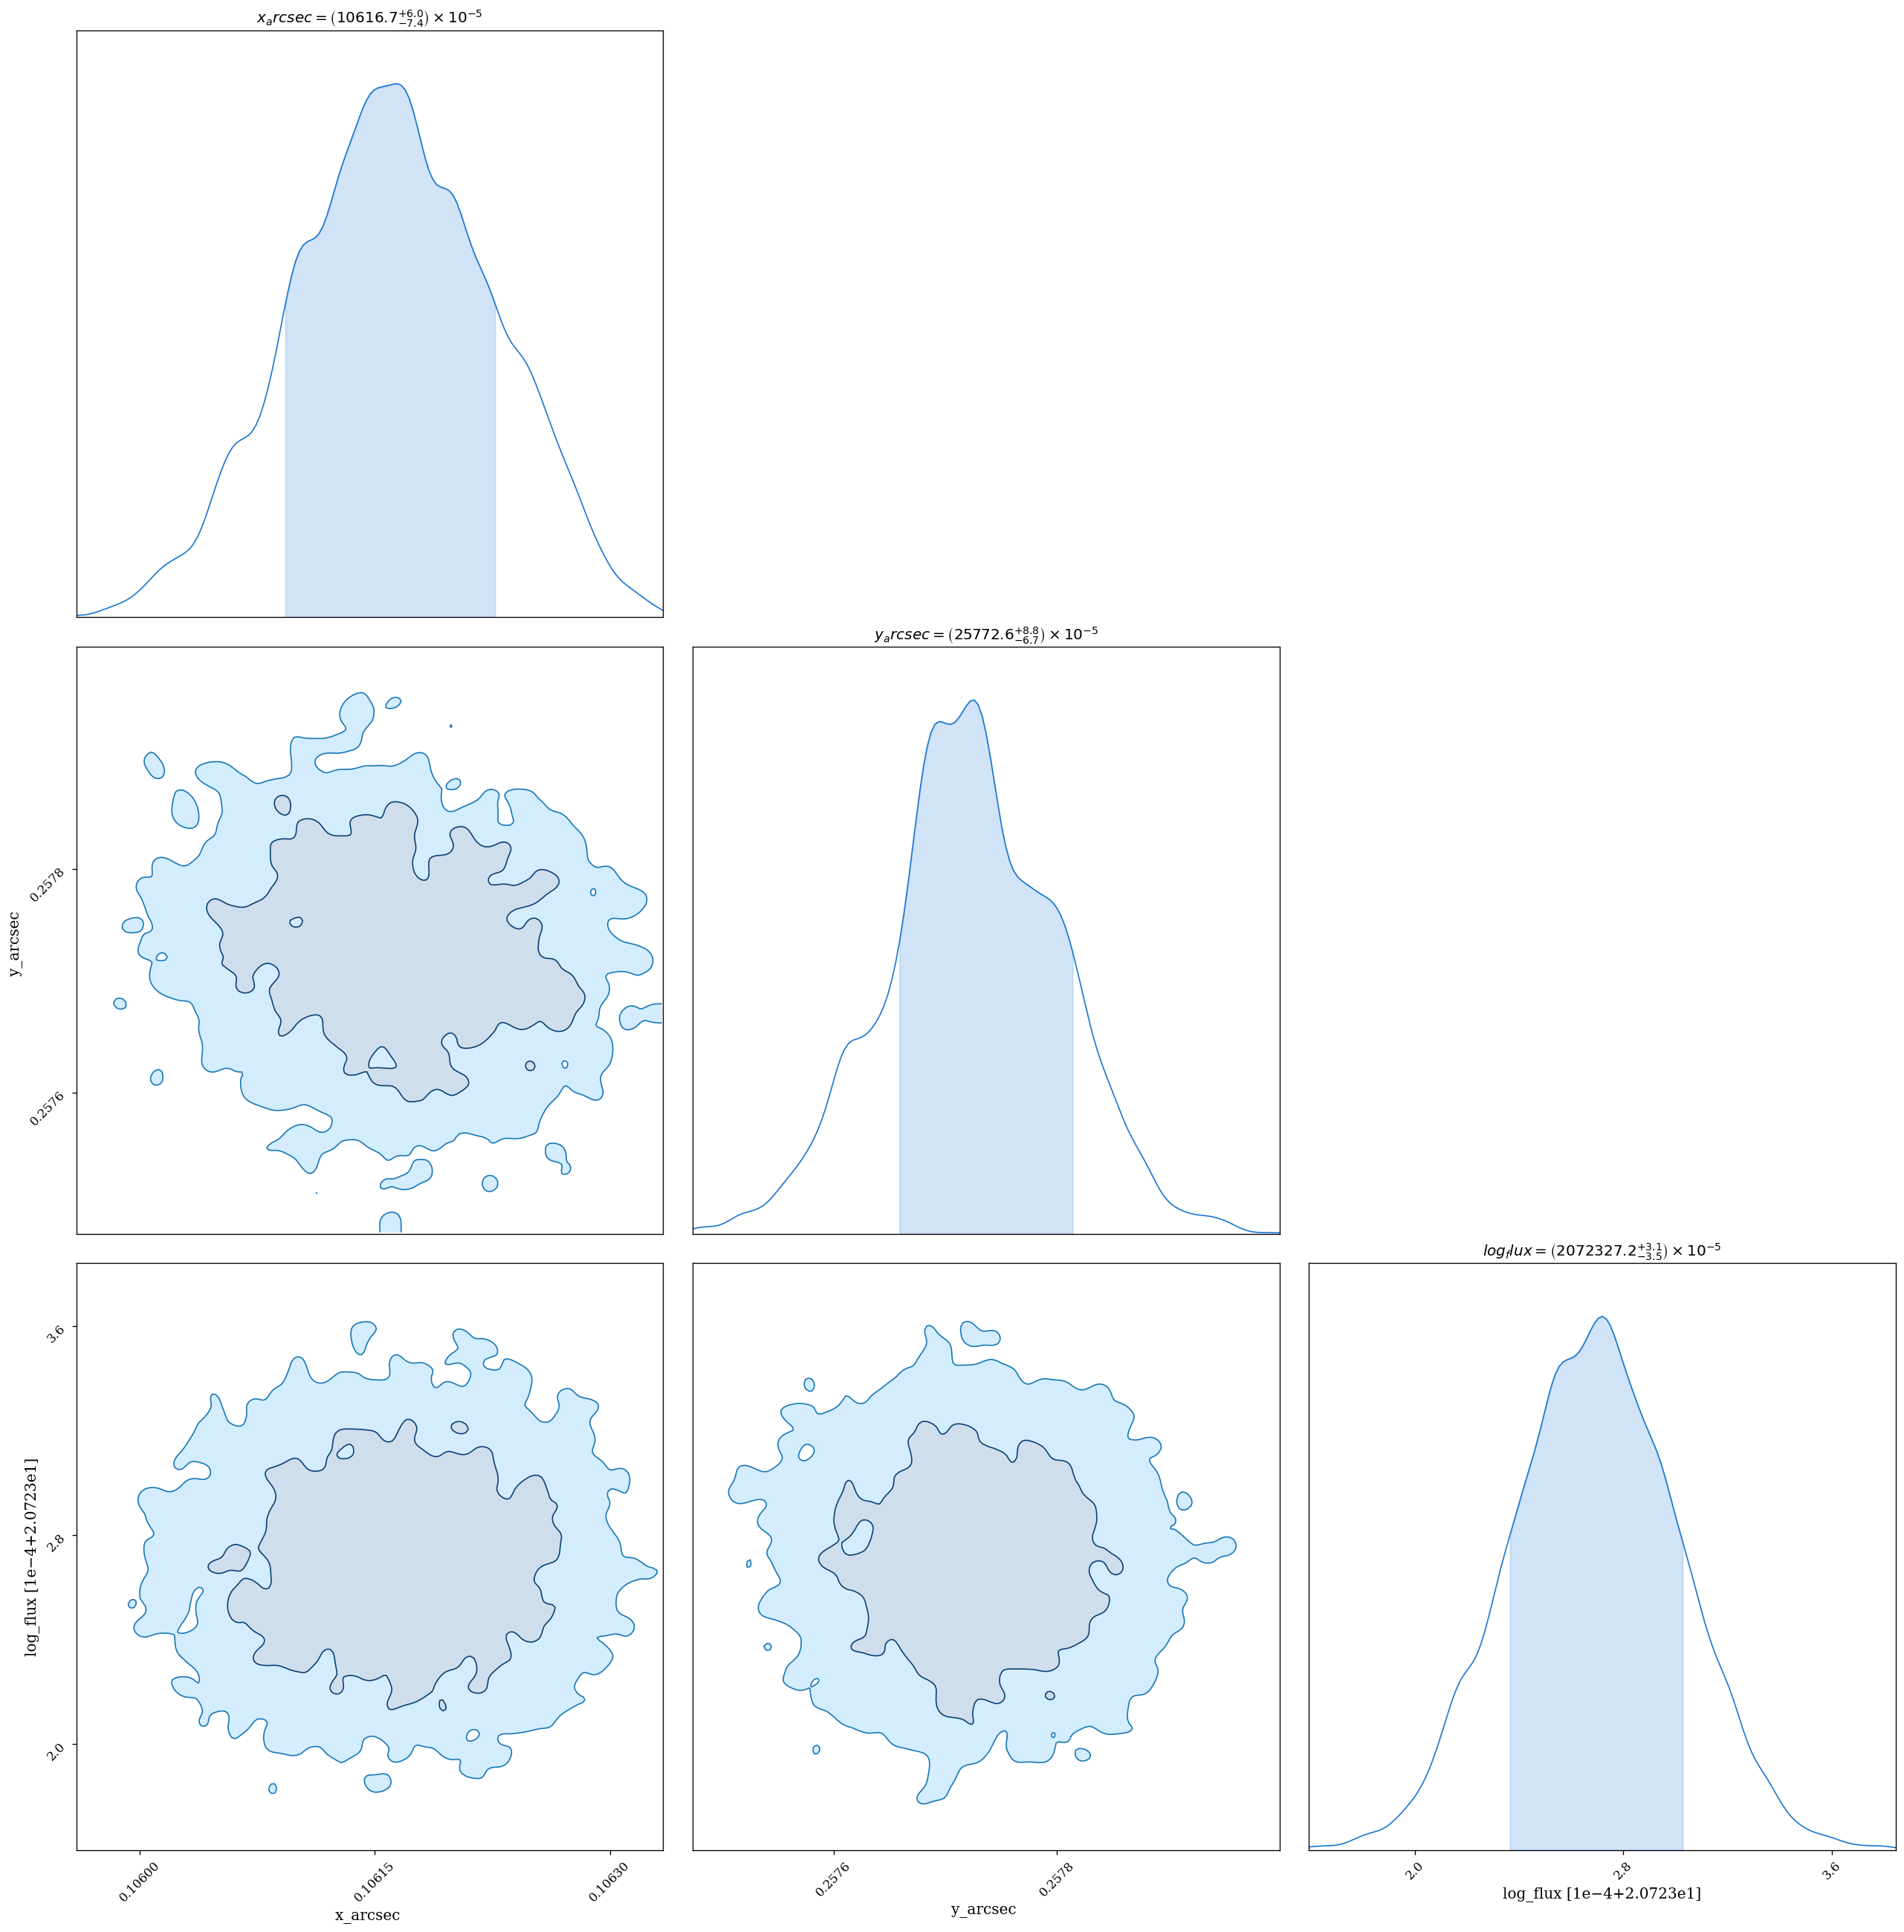

In [23]:

truths = {
    "x_arcsec": toArcsec(source_offset_x),
    "y_arcsec": toArcsec(source_offset_y),
    "log_flux": np.log(flux)
}

for idx, c in enumerate(coeffs):
    truths[f'p{idx}'] = c / phase_scale

values_small = {k: values_out[k] for k in ('x_arcsec', 'y_arcsec', 'log_flux')}


chain = cc.ChainConsumer()
chain.add_chain(values_small)
chain.configure_truth(color='r', ls=":", alpha=0.8)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot(truth=truths)
fig.set_size_inches((24, 24));

In [35]:
#import arviz as az
#az.plot_trace(az.from_numpyro(sampler))

In [24]:
mean_vals = {k: np.mean(v) for k, v in values_out.items()}

x_predicted = toRad(mean_vals["x_arcsec"])
y_predicted = toRad(mean_vals["y_arcsec"])
flux_predicted = np.exp(mean_vals["log_flux"])

coeffs_pred_all = [0] * n_coeffs
for i, z in itertools.product(range(n_mirrors), range(zernike_terms)):
    coeff_index = i*zernike_terms + z
    if (z, i) in fixed_mirrors:
        coeffs_pred_all[coeff_index] = fixed_mirrors[(z,i)]
    else:
        coeffs_pred_all[coeff_index] = mean_vals[f'p{coeff_index}'] * phase_scale

coeffs_pred_all = np.array(coeffs_pred_all)

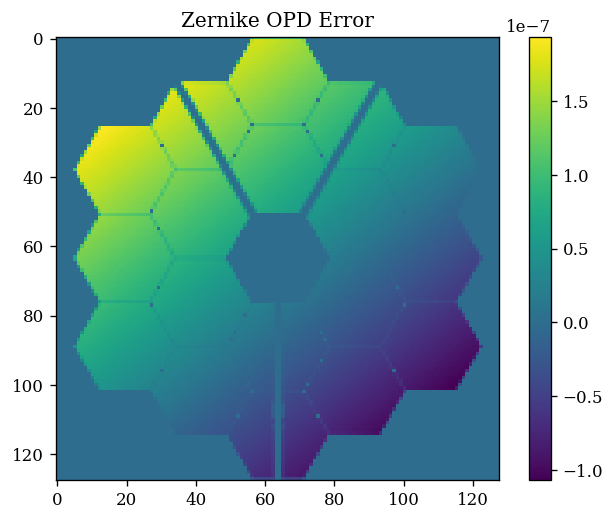

In [25]:
base_aberrations = get_aber(coeffs, basis_flat)
rec_aberrations = get_aber(coeffs_pred_all, basis_flat)

plt.title("Zernike OPD Error")
plt.imshow((base_aberrations-rec_aberrations)*telescope.pupil.transmission)

plt.colorbar()

In [26]:
def plot_corellation(order, label):
    plot_coeffs = coeffs[order::zernike_terms]
    plot_coeffs_rec = coeffs_pred_all[order::zernike_terms]

    fig = plt.figure(constrained_layout=True,figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(plot_coeffs*1e9, plot_coeffs_rec*1e9,'.', markersize=12,color='C0',label='Recovered')
    ax.plot(plot_coeffs*1e9, np.zeros(len(plot_coeffs))*1e9,'.', markersize=12,color='C1',label='Initial')

    ax.plot(np.array([np.min(plot_coeffs),np.max(plot_coeffs)])*1e9,
                   np.array([np.min(plot_coeffs),np.max(plot_coeffs)])*1e9,
                   '-',color='C2',label='1:1')
    ax.legend()
    ax.set_title(f'Correlation Plot {label}')

    ax.set_xlabel('True Zernike Coefficients (nm)')
    ax.set_ylabel('Model Zernike Coefficients (nm)')

    plt.show()

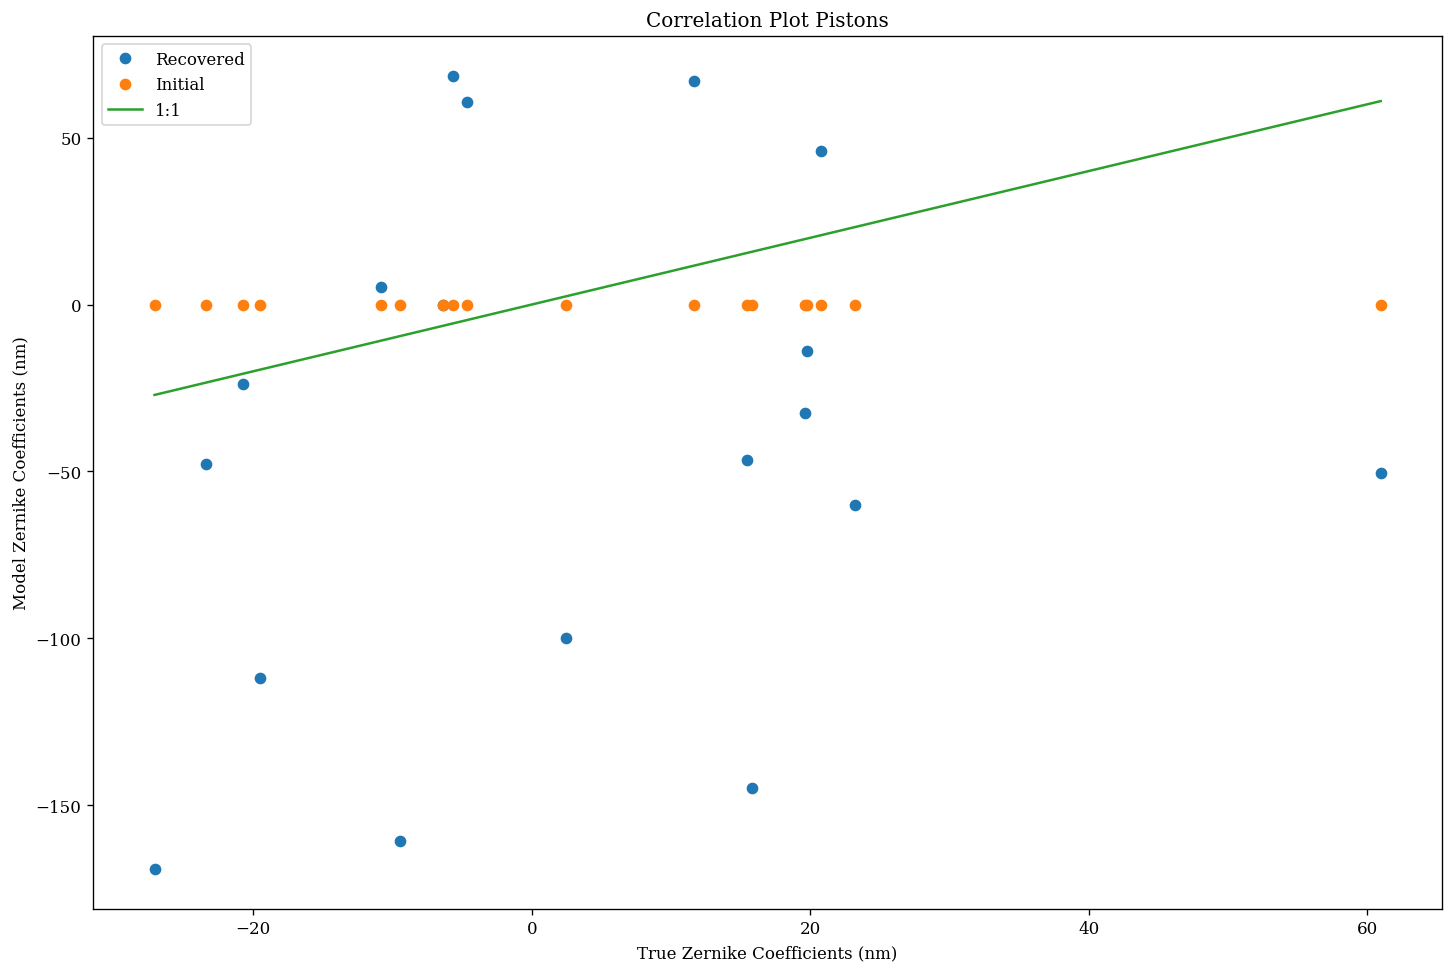

In [27]:
plot_corellation(0, 'Pistons')

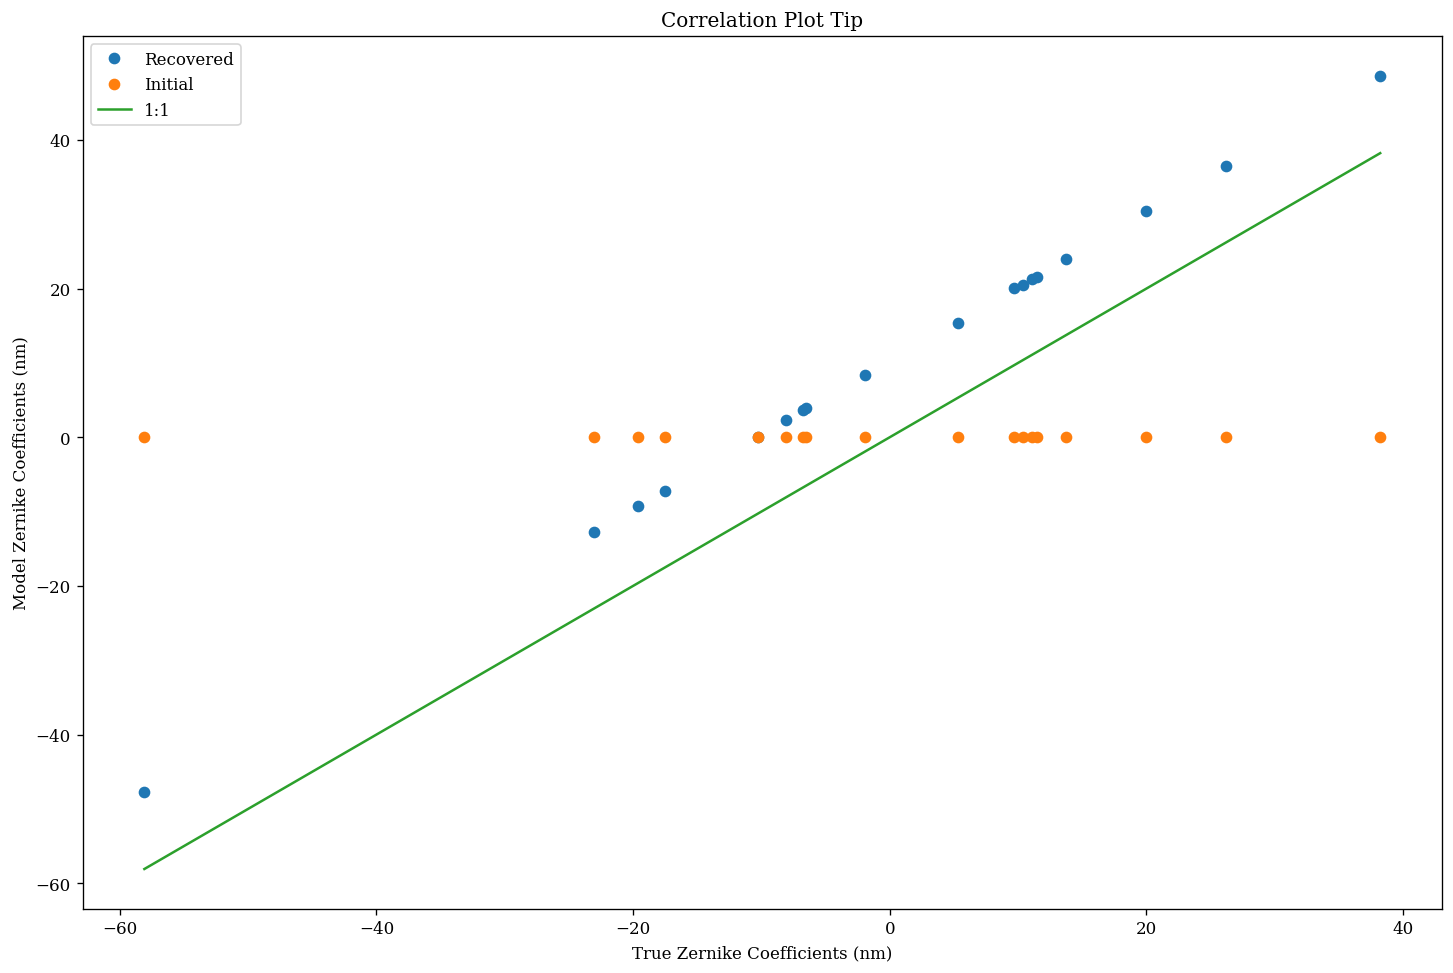

In [28]:
plot_corellation(1, 'Tip')

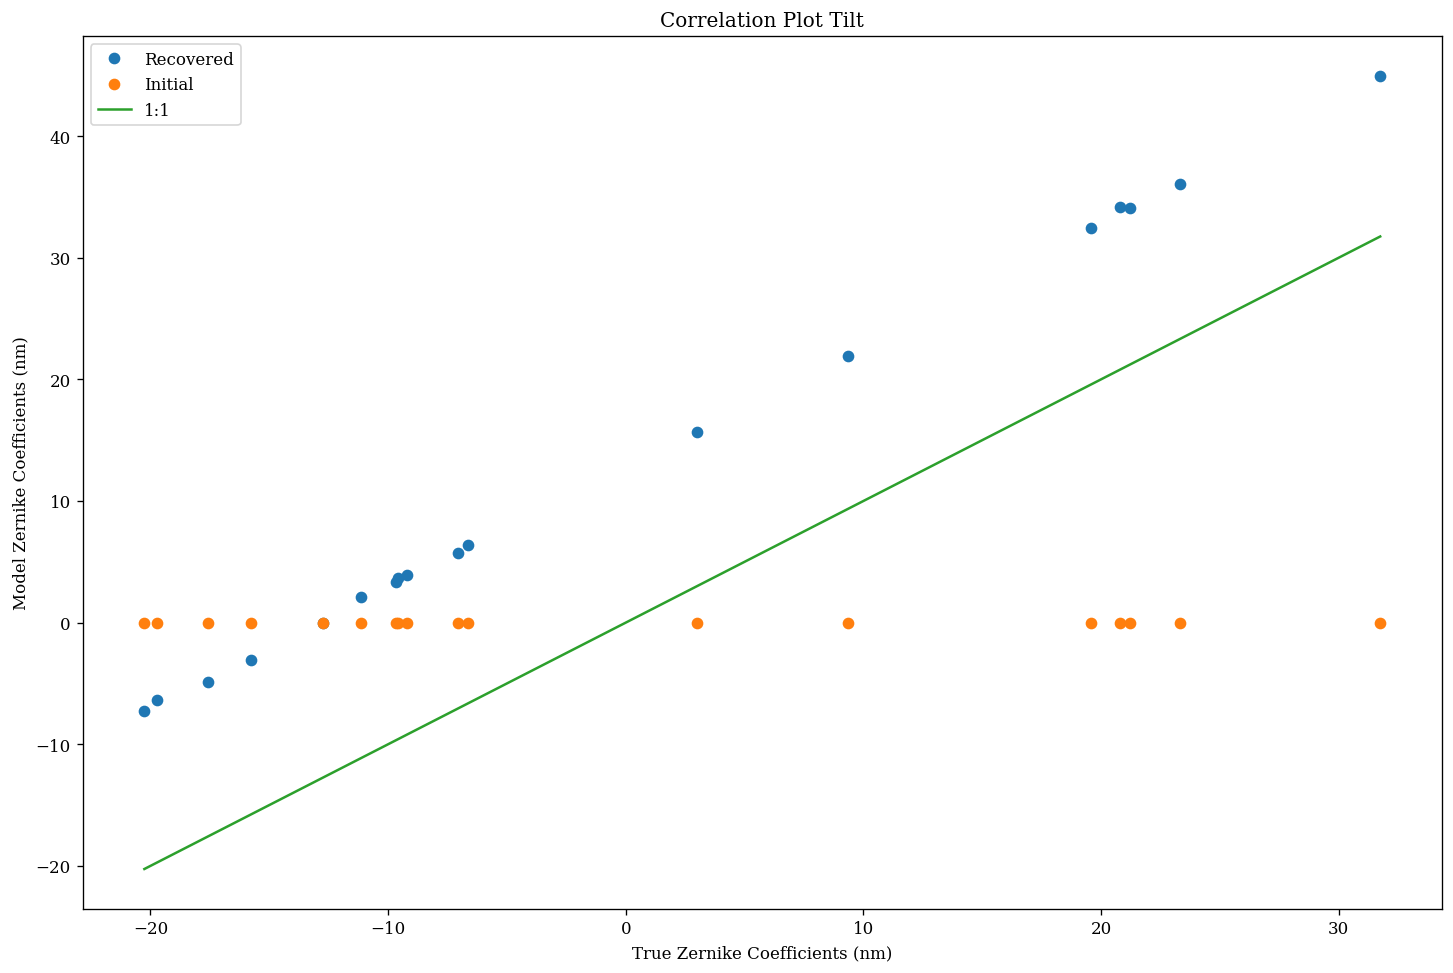

In [29]:
plot_corellation(2, 'Tilt')

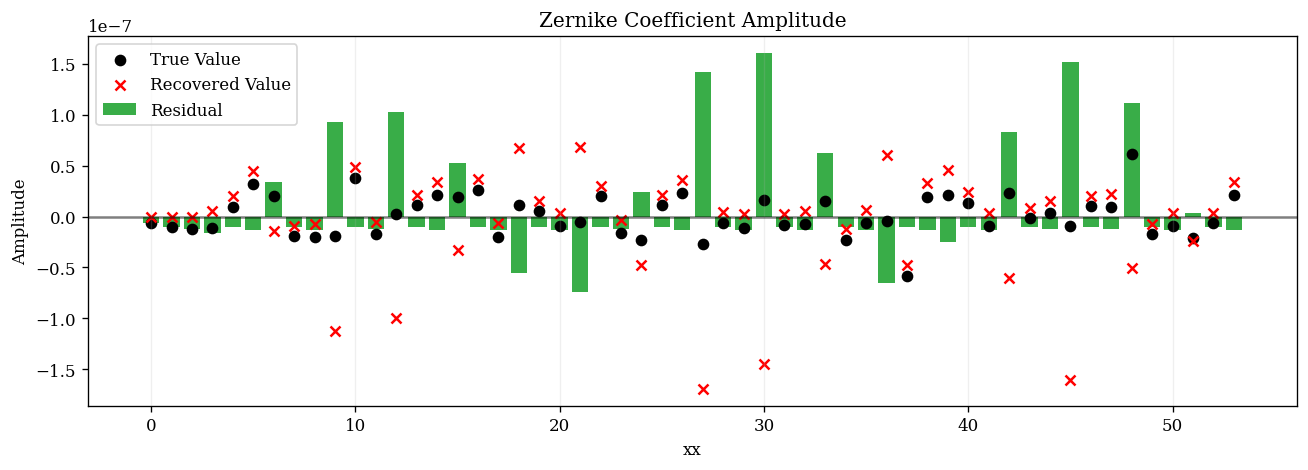

In [30]:
index = np.arange(0, n_coeffs)

plt.figure(figsize=(13, 4))
plt.title("Zernike Coefficient Amplitude")
plt.xlabel("xx")
plt.ylabel("Amplitude")

plt.grid(alpha=0.2, axis='x')
plt.scatter(index, coeffs, label="True Value", c='k')
plt.scatter(index, coeffs_pred_all, label="Recovered Value", marker='x', c='red')
plt.bar(index, coeffs -coeffs_pred_all, label='Residual', color='#39ad48', zorder=-1)
plt.axhline(0, c='k', alpha=0.5)
plt.legend()
plt.savefig('coefficients.pdf', dpi=300)
plt.show()

In [31]:
values_found = [
    np.array([x_predicted, y_predicted]),
    coeffs_pred_all,
    np.log(flux_predicted)
]

params_found = [
    'source.position',
    'pupil.coefficients',
    'source.flux'
]

psf_found = norm(model.set(params_found, values_found).model())

Text(0.5, 1.0, 'Residual')

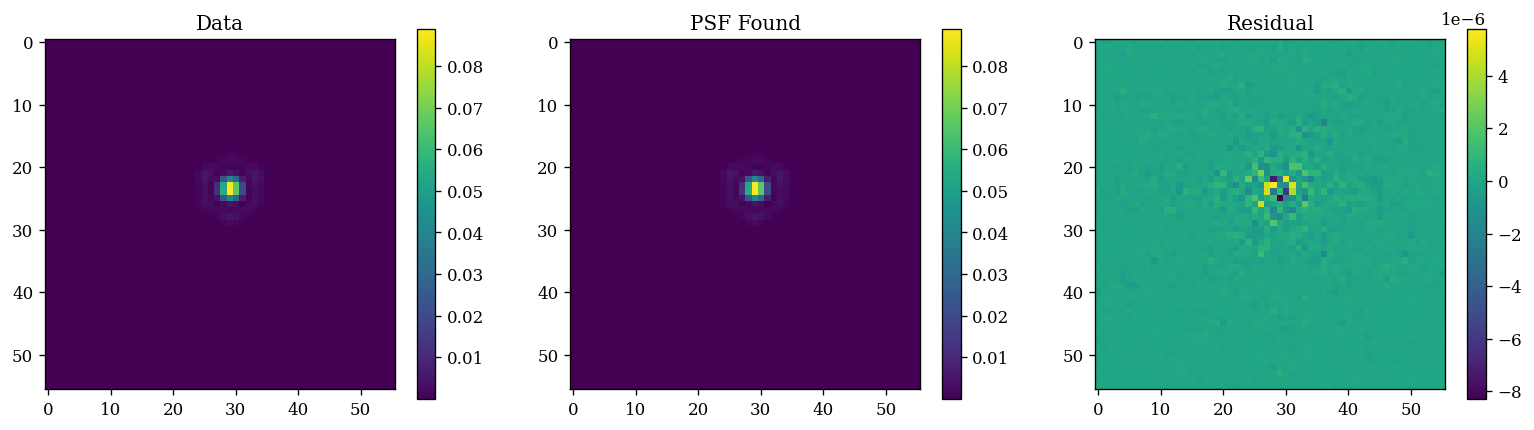

In [32]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)

plt.imshow(data)
plt.colorbar()
plt.title("Data")

plt.subplot(1, 3, 2)

plt.imshow(psf_found)
plt.colorbar()
plt.title("PSF Found")
plt.subplot(1, 3, 3)

plt.imshow(data - psf_found)
plt.colorbar()
plt.title("Residual")

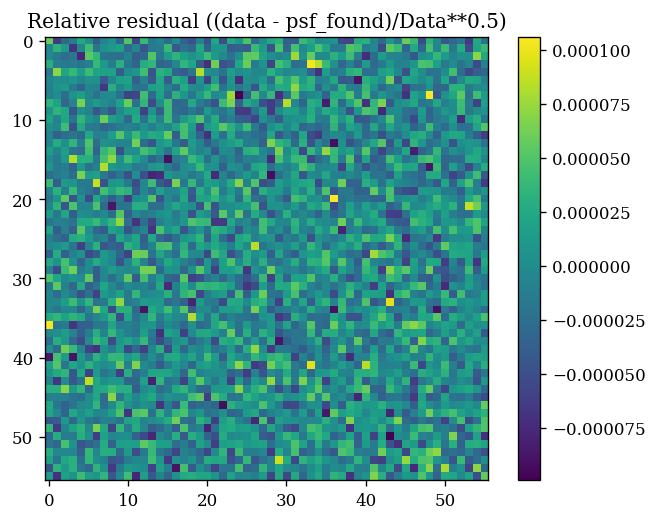

In [33]:
residual = data - psf_found
rel_resid = residual / data**0.5
plt.imshow(rel_resid)
plt.colorbar()
plt.title("Relative residual ((data - psf_found)/Data**0.5)")
plt.show()